In [1]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrix, dmatrices

# Relationship between GPCR class and constraint

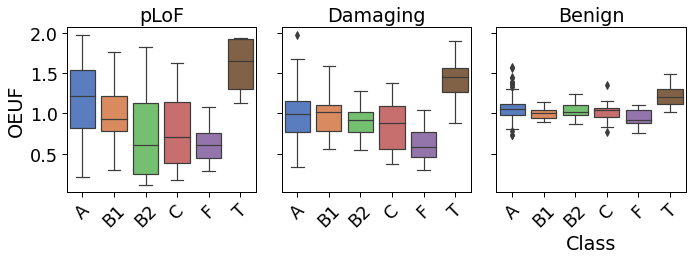

In [2]:
constraint_by_target_gene = pd.read_csv('../data/constraint/constraint_by_target_gene.csv')
gpcr_classes = pd.read_csv('../data/target_genes/GPCRdb_class_by_gpcr.csv')

constraint_by_class = gpcr_classes.merge(constraint_by_target_gene,left_on='HGNC symbol',right_on='symbol')
constraint_by_class = constraint_by_class[constraint_by_class.Class != 'Other']

sns.set_context('paper',font_scale=2)
fig, axes = plt.subplots(1,3,figsize=(10,4),sharey=True)
levels = ['A','B1','B2','C','F','T']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']

for ax, metric, annotation in zip(axes, metrics, annotations):
    sns.boxplot(
        data=constraint_by_class,
        x='Class',
        y=metric,
        ax=ax,
        palette='muted'
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_yticks(np.arange(0.5,2.5,0.5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(annotation)

axes[0].set_ylabel('OEUF')
axes[-1].set_xlabel('Class')
plt.tight_layout()
plt.savefig('../plots/constraint_by_class_boxplot.png',dpi=800)

In [3]:
constraint_by_class.groupby('Class').agg({'oe_lof_upper':np.median})

,oe_lof_upper
Class,
A,1.2145
B1,0.9310
B2,0.6055
C,0.7015
F,0.6060
T,1.6530


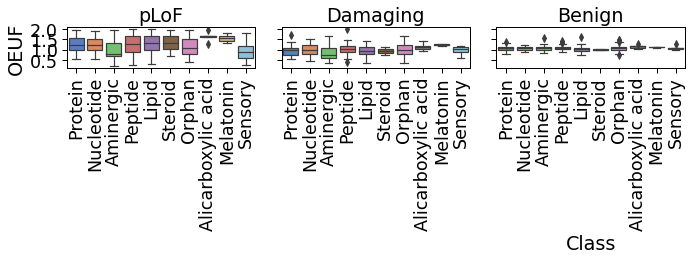

In [21]:

fig, axes = plt.subplots(1,3,figsize=(10,4),sharey=True)
for ax, metric, annotation in zip(axes, metrics, annotations):
    sns.boxplot(
        data=constraint_by_class[constraint_by_class.Class=='A'],
        x='Ligand_type',
        y=metric,
        ax=ax,
        palette='muted'
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_yticks(np.arange(0.5,2.5,0.5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(annotation)
axes[0].set_ylabel('OEUF')
axes[-1].set_xlabel('Class')
plt.tight_layout()

In [12]:
constraint_by_class[['Class','oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']].groupby('Class').median()

,oe_lof_upper,oe_mis_pphen_upper,oe_mis_non_pphen_upper
Class,,,
A,1.2145,0.9860,1.0580
B1,0.9310,1.0170,1.0000
B2,0.6055,0.9210,1.0180
C,0.7015,0.8775,1.0375
F,0.6060,0.5840,0.9200
T,1.6530,1.4510,1.2010


In [22]:
constraint_by_class[constraint_by_class.Class=='A'][['Ligand_type','oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']].groupby('Ligand_type').median()

,oe_lof_upper,oe_mis_pphen_upper,oe_mis_non_pphen_upper
Ligand_type,,,
Alicarboxylic acid,1.630,1.1100,1.1530
Aminergic,0.809,0.7320,1.0550
Lipid,1.295,0.9300,1.0410
Melatonin,1.531,1.2270,1.1165
Nucleotide,1.219,0.9925,1.0835
Orphan,1.076,0.9700,1.0545
Peptide,1.268,1.0460,1.0640
Protein,1.214,0.9970,1.0520
Sensory,0.894,1.0320,1.0720


<AxesSubplot:ylabel='Frequency'>

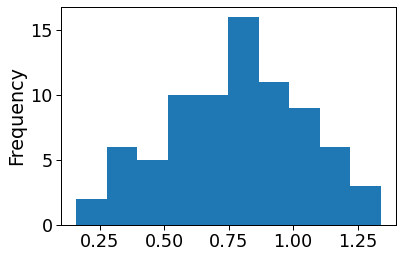

In [40]:
constraint_by_class[(constraint_by_class.Class=='A') & (constraint_by_class['Ligand_type']=='Orphan')]['oe_mis_pphen'].plot(kind='hist')

In [12]:
(constraint_by_class[(constraint_by_class.Class=='A') & (constraint_by_class['Ligand_type']=='Orphan')]['oe_mis_pphen_upper'] < 0.6).sum()

9

In [13]:
(constraint_by_class[(constraint_by_class.Class=='A') & (constraint_by_class['Family']=='Chemokine')]['oe_mis_pphen_upper'] < 0.6).sum()

4

In [37]:
constraint_by_class[(constraint_by_class.Class=='A') & (constraint_by_class['Ligand_type']=='Orphan')].__len__()

78

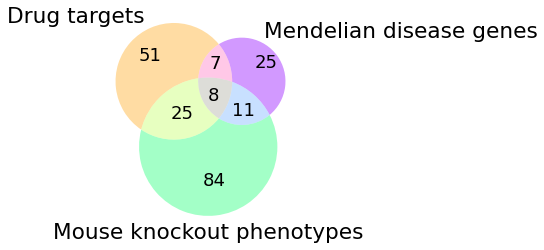

In [51]:
# Show base gene annotations
sns.set_context('talk')
gpcr_genetic_diseases = pd.read_csv('../data/disease_annotations/Schoeneberg2021_genetic_diseases_by_gpcr.csv')
gpcr_drug_targets = pd.read_csv('../data/drug_annotations/GPCR_drug_targets_by_MOAsmp_and_ATClvl1.csv',index_col=0)
gpcr_mouse_phenotypes = pd.read_csv('../data/disease_annotations/IMPC_knockout_mouse_phenotypes_by_gpcr.csv',index_col=0)
gpcr_mouse_phenotypes = gpcr_mouse_phenotypes[~gpcr_mouse_phenotypes.mouse_phenotype_hits.isna()]
#gpcr_lethal_mouse_phenotypes = gpcr_mouse_phenotypes[gpcr_mouse_phenotypes.mouse_phenotype_hits.str.contains('lethality')]
venn3(
    subsets = (
    set(list(gpcr_drug_targets['HGNC symbol'])),
    set(list(gpcr_genetic_diseases['HGNC symbol'])),
    set(list(gpcr_mouse_phenotypes['HGNC symbol']))
    ),
    set_labels=('Drug targets','Mendelian disease genes','Mouse knockout phenotypes'),
    set_colors=['#FFA919','#9000FF','#19FF75']
)
plt.tight_layout(h_pad=5)
plt.savefig('../plots/phenotypes_venn_diagram.png')

In [14]:
gpcr_targets = pd.read_csv('../data/target_genes/target_gene_names_combined.csv',index_col=0)
# Precomputed constraint metrics from gnomAD
constraint_by_target_gene = pd.read_csv('../data/constraint/constraint_by_target_gene.csv')
# Genetic disease data (curated)
gpcr_genetic_diseases = pd.read_csv('../data/disease_annotations/Schoeneberg2021_genetic_diseases_by_gpcr.csv')

gpcr_targets_by_genetic_disease = gpcr_targets.merge(gpcr_genetic_diseases,how='left',left_on='symbol',right_on='HGNC symbol')
gpcr_targets_by_genetic_disease = gpcr_targets_by_genetic_disease[['symbol','Functional_effect','Inheritance_pattern']]
gpcr_targets_by_genetic_disease['Functional_effect'] = gpcr_targets_by_genetic_disease['Functional_effect'].fillna('None')
gpcr_targets_by_genetic_disease['Inheritance_pattern'] = gpcr_targets_by_genetic_disease['Inheritance_pattern'].fillna('None')
gpcr_targets_by_genetic_disease['Inheritance_pattern_simplified'] = gpcr_targets_by_genetic_disease['Inheritance_pattern'].map(
    {'None':'None',
     'Autosomal recessive':'Autosomal recessive',
     'Autosomal dominant':'Dominant or X-linked',
     'X-linked':'Dominant or X-linked',
     'X-linked recessive':'Dominant or X-linked'
    }
)
gpcr_targets_by_genetic_disease= gpcr_targets_by_genetic_disease.drop(
    columns = 'Inheritance_pattern'
)
gpcr_targets_by_genetic_disease = gpcr_targets_by_genetic_disease.pivot(
    index='symbol',
    columns='Functional_effect'
)
gpcr_targets_by_genetic_disease = gpcr_targets_by_genetic_disease.fillna('None')
gpcr_targets_by_genetic_disease.columns = ['Activating_disease','Inactivating_disease','None']
gpcr_targets_by_genetic_disease = gpcr_targets_by_genetic_disease.drop(columns ='None')
gpcr_targets_by_constraint_and_disease = gpcr_targets_by_genetic_disease.merge(constraint_by_target_gene,on='symbol')
gpcr_targets_by_constraint_and_disease = gpcr_targets_by_constraint_and_disease[[
    'symbol','Activating_disease','Inactivating_disease','oe_mis_pphen_upper','oe_lof_upper','oe_mis_non_pphen_upper'
]]
gpcr_targets_by_constraint_and_disease

,symbol,Activating_disease,Inactivating_disease,oe_mis_pphen_upper,oe_lof_upper,oe_mis_non_pphen_upper
0,ACKR1,None,None,1.287,1.598,1.181
1,ACKR2,None,None,1.338,1.470,0.990
2,ACKR3,None,None,0.703,0.682,1.058
3,ACKR4,None,None,0.997,1.803,1.052
4,ADCYAP1R1,None,None,0.909,0.866,0.944
...,...,...,...,...,...,...
387,TSHR,Autosomal recessive,Dominant or X-linked,0.988,1.259,1.085
388,UTS2R,None,None,1.020,1.925,0.990
389,VIPR1,None,None,1.108,1.730,1.033
390,VIPR2,None,None,1.017,1.050,0.977


In [22]:
(~gpcr_targets_by_genetic_disease.isin(('None','Autosomal recessive'))).sum()

Activating_disease       9
Inactivating_disease    21
dtype: int64

In [30]:
# All GPCR targets
gpcr_targets = pd.read_csv('../data/target_genes/GuideToPharm_GPCR_targets_refined_060121.csv')
# Precomputed constraint metrics from gnomAD
gpcr_constraint = pd.read_csv('../data/constraint/constraint_by_target_gene.csv',index_col=0)
# Drug target data 
gpcr_drug_targets = pd.read_csv('../data/drug_annotations/GPCR_drug_targets_by_MOAsmp_and_ATClvl1.csv',index_col=0)
# Drug target class
gpcr_classes = pd.read_csv('../data/target_genes/GPCRdb_class_by_gpcr.csv')


gpcr_targets_ClassA = gpcr_targets.merge(
    gpcr_classes[gpcr_classes['Class']=='A'],
    on='HGNC symbol'
)

gpcr_targets_by_associated_drugs = gpcr_targets_ClassA.merge(gpcr_drug_targets,how='left',on='HGNC symbol')
gpcr_targets_by_associated_drugs = gpcr_targets_by_associated_drugs[
    ['HGNC symbol','MOA_simplified']
]

gpcr_targets_by_associated_drugs['MOA_simplified'] = \
    gpcr_targets_by_associated_drugs['MOA_simplified'].fillna('None')
gpcr_targets_by_associated_drugs = gpcr_targets_by_associated_drugs.rename(columns={'HGNC symbol':'symbol'})
gpcr_targets_by_constraint_and_drugs = (gpcr_targets_by_associated_drugs
    .merge(gpcr_constraint,on='symbol'))
#     .merge(gpcr_classes, on='HGNC symbol'))
#gpcr_targets_by_associated_drugs
gpcr_targets_by_constraint_and_drugs

,symbol,MOA_simplified,name,synonyms,oe_lof,oe_lof_lower,oe_lof_upper,oe_mis_pphen,oe_mis_pphen_lower,oe_mis_pphen_upper,oe_mis_non_pphen,oe_mis_non_pphen_lower,oe_mis_non_pphen_upper
0,ACKR1,None,ACKR1,Duffy antigen/chemokine receptor|atypical chem...,0.83471,0.455,1.598,1.04200,0.848,1.287,1.08220,0.992,1.181
1,ACKR2,None,ACKR2,CCR10|CCR9|CMBRK9|C-C chemokine receptor D6|ch...,0.71029,0.370,1.470,1.09220,0.896,1.338,0.89959,0.818,0.990
2,ACKR3,None,ACKR3,chemokine (C-X-C motif) receptor 7|chemokine o...,0.21676,0.088,0.682,0.53228,0.407,0.703,0.95841,0.869,1.058
3,ACKR4,None,ACKR4,CC-CKR-11|CCR10|CKR-11|CCR11|PPR1|VSHK1,1.18710,0.755,1.803,0.77786,0.612,0.997,0.95686,0.871,1.052
4,ADORA1,activating,A<sub>1</sub> receptor,RDC7|adenosine receptor A1|A1-AR|A1R,0.48097,0.236,1.100,0.33817,0.251,0.461,0.86000,0.809,0.913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,TBXA2R,None,TP receptor,prostanoid TP receptor|TXA2-R,0.72739,0.413,1.361,0.78109,0.658,0.930,1.02950,0.970,1.092
446,TRHR,None,TRH<sub>1</sub> receptor,TRH receptor|thyroliberin receptor|TRH-R|TRH-R1,0.24688,0.111,0.638,0.65739,0.517,0.843,0.88129,0.792,0.981
447,TSHR,None,TSH receptor,Thyrotropin Receptor|LGR3|TSH-R,0.89504,0.647,1.259,0.86156,0.752,0.988,1.02200,0.962,1.085
448,UTS2R,None,UT receptor,GPR14|UII-R1|UTR2|G protein-coupled receptor 1...,1.44270,0.733,1.925,0.82303,0.668,1.020,0.89740,0.813,0.990


In [ ]:
gpcr_targets_by_genetic_disease

In [32]:
gpcr_mouse_phenotypes = pd.read_csv('../data/disease_annotations/IMPC_knockout_mouse_phenotypes_by_gpcr.csv',index_col=0)
gpcr_mouse_phenotypes = gpcr_mouse_phenotypes[~gpcr_mouse_phenotypes.num_mouse_phenotype_hits.isna()]
gpcr_mouse_phenotypes['effect'] = np.select(
    [
        (gpcr_mouse_phenotypes['mouse_phenotype_hits'].str.contains('lethality') & \
              ~gpcr_mouse_phenotypes['mouse_phenotype_hits'].isna()),
        (gpcr_mouse_phenotypes['num_mouse_phenotype_hits'] > 0)
    ], 
    [
        'Lethal', 
        'Non-lethal'
    ], 
    default='None'
)
constraint_by_mouse_phenotype = gpcr_mouse_phenotypes.merge(constraint_by_target_gene,left_on='HGNC symbol',right_on='symbol',how='left') 
#= gpcr_mouse_phenotypes[gpcr_mouse_phenotypes.mouse_phenotype_hits.str.contains('lethality')]

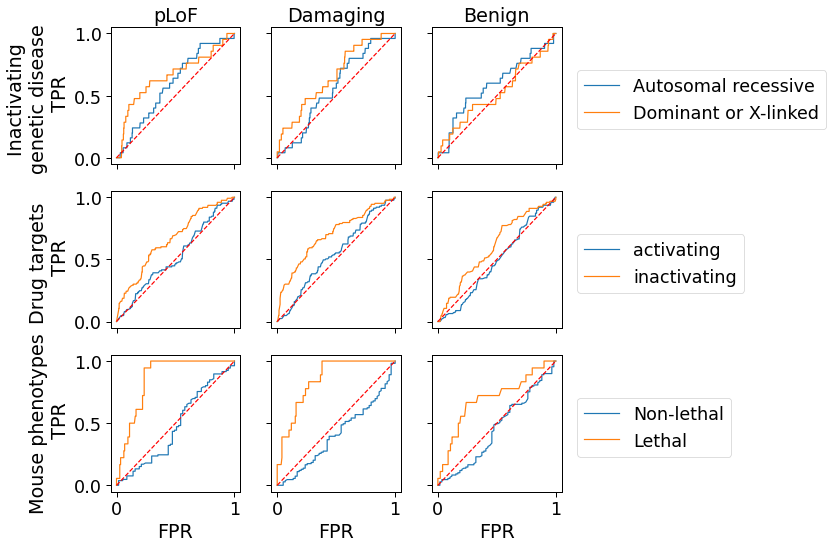

In [41]:
fig, axes = plt.subplots(3,3,figsize=(12,8),sharey=True, sharex=True)
sns.set_context('paper',font_scale=2)
# Genetic diseases
regdf = gpcr_targets_by_constraint_and_disease
levels = ['None','Autosomal recessive','Dominant or X-linked']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes[0]):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(Inactivating_disease,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        fpr, tpr, _ = roc_curve(y[:,i],-X)
        ax_.plot(fpr,tpr,label=label)
    ax_.set_title(annotation)    
    ax_.plot((0,1),(0,1),'r--')
    #ax_.set_xlabel('FPR')
    #ax_.set_ylabel('TPR')
    
axes[0][0].set_ylabel('Inactivating \ngenetic disease \n TPR')
axes[0][-1].legend(bbox_to_anchor=(1.05, 0.75))

# Drug targets
regdf = gpcr_targets_by_constraint_and_drugs
levels = ['None','activating','inactivating']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes[1]):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(MOA_simplified,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        fpr, tpr, _ = roc_curve(y[:,i],-X)
        ax_.plot(fpr,tpr,label=label)
    #ax_.set_title(annotation)    
    ax_.plot((0,1),(0,1),'r--')
    #ax_.set_xlabel('FPR')
    #ax_.set_ylabel('TPR')
axes[1][0].set_ylabel('Drug targets \n TPR')
axes[1][-1].legend(bbox_to_anchor=(1.05, 0.75))

# Mouse phenotypes
regdf = constraint_by_mouse_phenotype
levels = ['None','Non-lethal','Lethal']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes[2]):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(effect,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        fpr, tpr, _ = roc_curve(y[:,i],-X)
        ax_.plot(fpr,tpr,label=label)
    #ax_.set_title(annotation)    
    ax_.plot((0,1),(0,1),'r--')
    ax_.set_xlabel('FPR')
    #ax_.set_ylabel('TPR')

axes[2][0].set_ylabel('Mouse phenotypes\n TPR')
axes[2][-1].legend(bbox_to_anchor=(1.05, 0.75))
plt.tight_layout()
plt.savefig('../plots/figure_2_roc_curves.png',dpi=600)

# GPCR drug targets

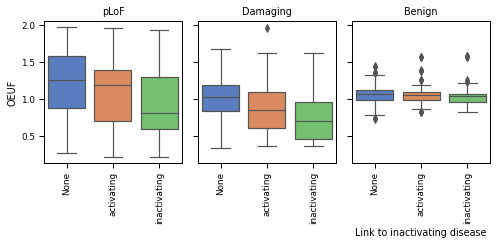

In [107]:
sns.set_context('paper')
sns.set_context('paper')
fig, axes = plt.subplots(1,3,figsize=(7,3.5),sharey=True)

annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']

for ax, metric, annotation in zip(axes, metrics, annotations):
    sns.boxplot(
        data=gpcr_targets_by_constraint_and_drugs,
        x='MOA_simplified',
        y=metric,
        ax=ax,
        palette='muted'
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_yticks(np.arange(0.5,2.5,0.5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(annotation)

axes[0].set_ylabel('OEUF')
axes[-1].set_xlabel('Link to inactivating disease')
plt.tight_layout()
plt.savefig('../plots/drug_target_constraint_boxplots_poster.png',dpi=500)

0.5231210191082802
0.6602860965318514
0.5458953846153847
0.6949976380497749
0.4856738461538462
0.6036771835608263


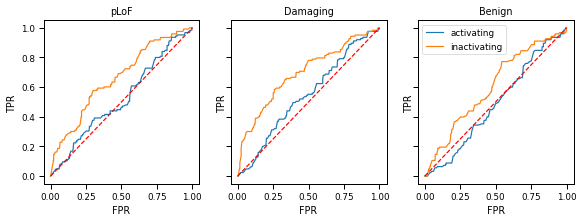

In [24]:
fig, axes = plt.subplots(1,3,figsize=(9.5,3),sharey=True)
regdf = gpcr_targets_by_constraint_and_drugs
levels = ['None','activating','inactivating']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(MOA_simplified,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        fpr, tpr, _ = roc_curve(y[:,i],-X)
        print(auc(fpr, tpr))
        ax_.plot(fpr,tpr,label=label)
    ax_.set_title(annotation)    
    ax_.plot((0,1),(0,1),'r--')
    ax_.set_xlabel('FPR')
    ax_.set_ylabel('TPR')
plt.legend()
plt.savefig('../plots/constraint_by_drug_target_roc.png',dpi=600)

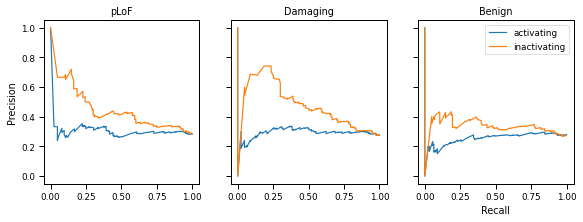

In [113]:
fig, axes = plt.subplots(1,3,figsize=(9.5,3),sharey=True)
regdf = gpcr_targets_by_constraint_and_drugs
levels = ['None','activating','inactivating']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(MOA_simplified,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        pr, rc, _ = precision_recall_curve(y[:,i],-X)
        ax_.plot(rc,pr,label=label)
    ax_.set_title(annotation)    
    #ax_.plot((0,1),(0,1),'r--')
axes[-1].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
plt.legend()
plt.savefig('../plots/constraint_by_drugs_prc.png',dpi=600)

# GPCRs associated with phenotypes in knockout mice

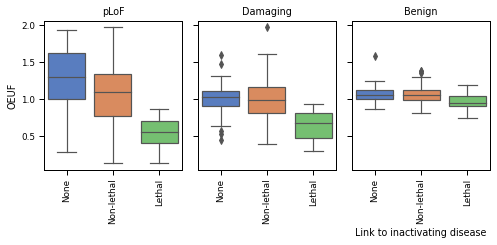

In [118]:
sns.set_context('paper')
fig, axes = plt.subplots(1,3,figsize=(7,3.5),sharey=True)

levels = ['None','Non-lethal','Lethal']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']

for ax, metric, annotation in zip(axes, metrics, annotations):
    sns.boxplot(
        data=constraint_by_mouse_phenotype,
        x='effect',
        y=metric,
        order=levels,
        ax=ax,
        palette='muted'
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_yticks(np.arange(0.5,2.5,0.5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(annotation)

axes[0].set_ylabel('OEUF')
axes[-1].set_xlabel('Link to inactivating disease')
plt.tight_layout()

0.4750910294604436
0.8595785440613027
0.4073238998600529
0.8498148148148148
0.4526512206499767
0.6961111111111112


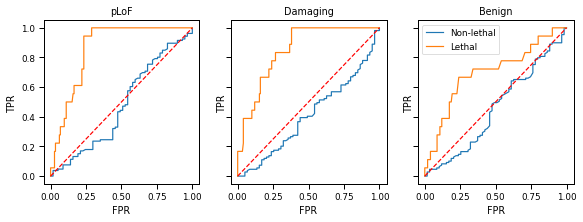

In [32]:
fig, axes = plt.subplots(1,3,figsize=(9.5,3),sharey=True)
regdf = constraint_by_mouse_phenotype
levels = ['None','Non-lethal','Lethal']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(effect,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        fpr, tpr, _ = roc_curve(y[:,i],-X)
        print(auc(fpr, tpr))
        ax_.plot(fpr,tpr,label=label)
    ax_.set_title(annotation)    
    ax_.plot((0,1),(0,1),'r--')
    ax_.set_xlabel('FPR')
    ax_.set_ylabel('TPR')
plt.legend()
plt.savefig('../plots/constraint_by_mouse_phenotype_roc.png',dpi=600)

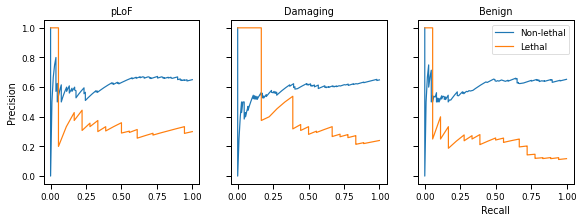

In [124]:
fig, axes = plt.subplots(1,3,figsize=(9.5,3),sharey=True)
regdf = constraint_by_mouse_phenotype
levels = ['None','Non-lethal','Lethal']
annotations = ['pLoF','Damaging','Benign']
metrics = ['oe_lof_upper','oe_mis_pphen_upper','oe_mis_non_pphen_upper']
for metric, annotation, ax_ in zip(metrics,annotations,axes):
    X = regdf[~regdf[metric].isna()][metric].rank()
    y = dmatrix('C(effect,levels=levels)',data=regdf[~regdf[metric].isna()],)
    
    for i, label in zip(range(1,6),levels[1:]):
        pr, rc, _ = precision_recall_curve(y[:,i],-X)
        ax_.plot(rc,pr,label=label)
    ax_.set_title(annotation)    
    #ax_.plot((0,1),(0,1),'r--')
axes[-1].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
plt.legend()
plt.savefig('../plots/constraint_by_mouse_phenotype_prc.png',dpi=600)

# Case studies

In [ ]:
# Haploinsufficient GPCRs
fig, (ax1, ax2) = plt.subplots(figsize=(8,8))
haploinsufficients = gpcr_constraint_by_class[gpcr_constraint_by_class['oe_lof_upper'] < 0.5]
lof_errors = np.stack((
    haploinsufficients['oe_lof'] - haploinsufficients['oe_lof_lower'],
    haploinsufficients['oe_lof_upper'] - haploinsufficients['oe_lof']
))
mis_errors = np.stack((
    haploinsufficients['oe_mis'] - haploinsufficients['oe_mis_lower'],
    haploinsufficients['oe_mis_upper'] - haploinsufficients['oe_mis']
))
ax1.errorbar(haploinsufficients['oe_mis_upper'], haploinsufficients['oe_lof_upper'],xerr=mis_errors,yerr=lof_errors,fmt='.k')
plt.xlabel('Obs/exp ratio for missense mutations (upper bound)')
plt.ylabel('Obs/exp ratio for pLoF mutations (upper bound)')
# for i, txt in enumerate(haploinsufficients['HGNC symbol']):
#     ax.annotate(txt, (haploinsufficients['oe_mis_upper'].values[i], haploinsufficients['oe_lof_upper'].values[i]))

sns.scatterplot(data=haploinsufficients,x='oe_mis_upper',y='oe_lof_upper',hue='Class',ax=ax2)

# GPCR tissue expression

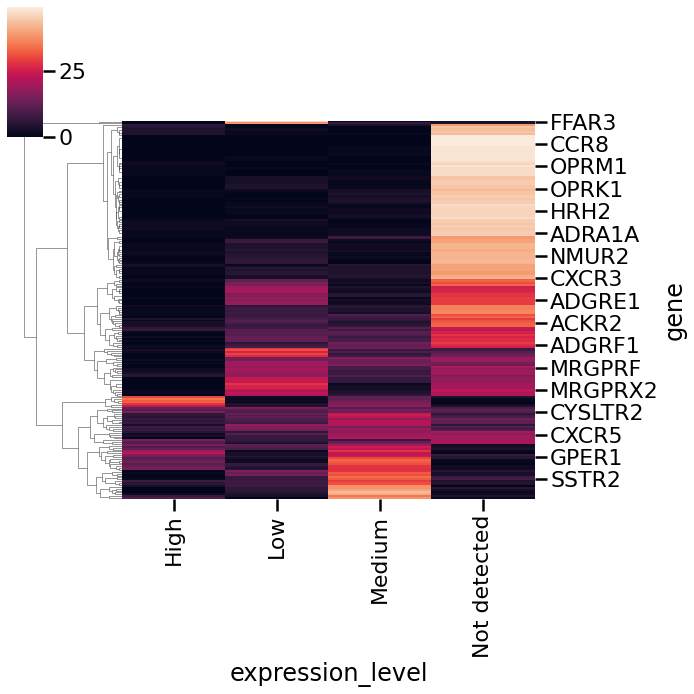

In [98]:
# Load expression levels across tissues 
gpcr_expression = pd.read_csv('../data/expression/filtered_protein_expression_by_tissue.csv',index_col=0)
gpcr_expression_tidy = pd.melt(gpcr_expression,id_vars='gene',var_name='tissue',value_name='expression_level')
gpcr_expression_tidy['expression_level_ordinal'] = gpcr_expression_tidy['expression_level'].map({
    'Not detected':0,
    'Low':1,
    'Medium':2,
    'High':3
})
gpcr_expression_wide = gpcr_expression_tidy.pivot_table(index='gene',columns = 'expression_level',values='expression_level_ordinal',aggfunc='count',fill_value=0)
sns.clustermap(gpcr_expression_wide,col_cluster=False)

<AxesSubplot:xlabel='expression_level_ordinal', ylabel='oe_mis_pphen_upper'>

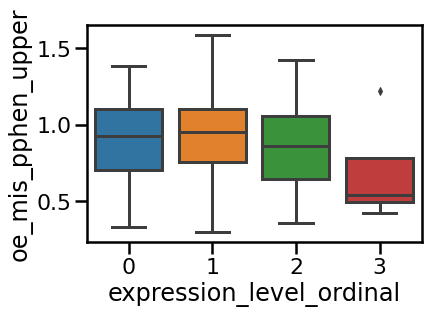

In [99]:
median_expression = gpcr_expression_tidy.groupby('gene').agg({'expression_level_ordinal':lambda x: np.median(x)}).reset_index()
gpcr_constraint_and_median_expression = constraint_by_target_gene.merge(median_expression,left_on='symbol',right_on='gene')
sns.boxplot(data=gpcr_constraint_and_median_expression,x='expression_level_ordinal',y='oe_mis_pphen_upper')


In [101]:
y1, X1 = dmatrices('oe_mis_pphen_upper ~ C(expression_level_ordinal)',data=gpcr_constraint_and_median_expression,NA_action='drop')
mod1 = sm.OLS(y1, X1)
res1 = mod1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     oe_mis_pphen_upper   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.228
Date:                Thu, 01 Jul 2021   Prob (F-statistic):              0.301
Time:                        11:31:21   Log-Likelihood:                -23.807
No. Observations:                 203   AIC:                             55.61
Df Residuals:                     199   BIC:                             68.87
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9022      0.025     35.665      0.000       0.852       0.952
C(expression_level_ordinal)[T.1]     0.0158      0.051      0.309      0.758      -0.085       0.117
C(expression_level_ordinal)[T.2]    -0.0419      0.049     -0.848      0.397      -0.139       0.055
C(expression_level_ordinal)[T.3]    -0.2092      0.125     -1.668      0.097      -0.457       0.038
==============================================================================
Omnibus:                        6.825   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                4.036
Skew:                          -0.148   Prob(JB):                        0.133
Kurtosis:                       2.376   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""